# 节点重要性排序和评估


导入包。


In [1]:
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

一个网络是一张无权无向图，使用它的邻接矩阵来表示。


In [2]:
Network = np.ndarray[np.ndarray[0 | 1]]

加载若干个网络。


In [3]:
with open("networks.json", "r") as file:
    networks: list[Network] = [np.asarray(network) for network in json.load(file)]

`find_neighbors` 函数找到一个节点在网络中的邻居。


In [4]:
def find_neighbors(network: Network, node: int):
    return np.nonzero(network[node])[0]

`simulate_SIR` 函数模拟 SIR 传播过程。

SIR 传播过程如下：

1. 在一个网络中，存在一些源感染者。为了简单起见，不妨假设源感染者只有一位。
2. 在每一轮传播中，每个感染者以概率 β 感染其邻居，以概率 γ 康复。
3. 当网络中的所有节点都康复时，传播过程结束。


In [5]:
def simulate_SIR(
    network: Network, source: int = 0, beta: float = 0.3, gamma: float = 0.1
):
    # 初始化各节点的状态。
    susceptible_nodes = set(range(network.shape[0])) - {source}
    infected_nodes = {source}
    recovered_nodes = set()

    # 记录各状态在各时刻上的节点数量。
    susceptible_counts = [len(susceptible_nodes)]
    infected_counts = [len(infected_nodes)]
    recovered_counts = [len(recovered_nodes)]

    # 如果还有感染者，SIR 传播过程就会继续。
    while infected_nodes:
        # 记录本轮新感染和新康复的节点。
        new_infected_nodes = set()
        new_recovered_nodes = set()

        # 对于每个感染者来说：
        for infected_node in infected_nodes:
            # 他会以概率 β 感染其邻居。
            neighbors = find_neighbors(network, infected_node)
            susceptible_neighbors = set(neighbors) & susceptible_nodes
            new_infected_neighbors = {
                susceptible_neighbor
                for susceptible_neighbor in susceptible_neighbors
                if np.random.rand() < beta
            }
            new_infected_nodes |= new_infected_neighbors

            # 他会以概率 γ 康复。
            if np.random.rand() < gamma:
                new_recovered_nodes.add(infected_node)

        # 更新各节点状态。
        susceptible_nodes -= new_infected_nodes
        infected_nodes = (infected_nodes | new_infected_nodes) - new_recovered_nodes
        recovered_nodes |= new_recovered_nodes

        # 更新各状态在当前时刻上的节点数量。
        susceptible_counts.append(len(susceptible_nodes))
        infected_counts.append(len(infected_nodes))
        recovered_counts.append(len(recovered_nodes))

    # 打包计数结果。
    counts = {
        "susceptible": susceptible_counts,
        "infected": infected_counts,
        "recovered": recovered_counts,
    }

    return counts

`visualize_SIR` 函数绘制 SIR 传播过程中，各状态在各时刻上的节点数量的堆积面积图。


In [6]:
def visualize_SIR(counts: dict[str, list[int]]):
    plt.stackplot(
        range(len(counts["infected"])),
        counts.values(),
        labels=counts.keys(),
        colors=["blue", "red", "green"],
        alpha=0.6,
    )
    plt.title("SIR Propagation")
    plt.xlabel("Days")
    plt.ylabel("Number")
    plt.margins(x=0, y=0)
    plt.legend()
    plt.show()

仿真一次 SIR 传播过程，并可视化。


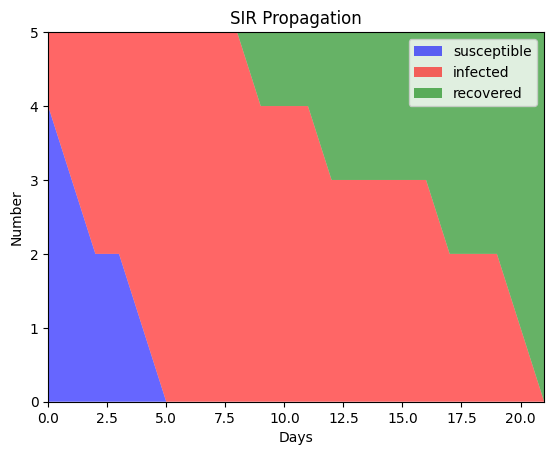

In [7]:
counts = simulate_SIR(networks[0])
visualize_SIR(counts)

`calculate_correlation` 函数计算两个序列的相关性系数。


In [8]:
def calculate_correlation(sequence1: list[int], sequence2: list[int]):
    # 计算两个长度为 1 的序列的相关性系数没有意义。
    assert len(sequence1) > 1 and len(sequence2) > 1

    # 逐一比较每一个变化对的正相关性和负相关性。
    pairs = list(zip(sequence1, sequence2))
    num_positive = 0
    num_negative = 0

    for index, (x1, y1) in enumerate(pairs[:-1]):
        for x2, y2 in pairs[index + 1 :]:
            if (x1 < x2 and y1 < y2) or (x1 > x2 and y1 > y2):
                num_positive += 1
            elif (x1 < x2 and y1 > y2) or (x1 > x2 and y1 < y2):
                num_negative += 1

    # 导出相关性系数。
    total = np.sum(range(len(sequence1)))
    correlation = np.round((num_positive - num_negative) / total, 3)

    return correlation

`k_shell_sort` 函数使用 k-shell 分解法，对节点进行排序。


In [9]:
def k_shell_sort(network: Network):
    # 转换为浮点型，以便在后面用 `inf` 表示已移除的节点。
    network = network.astype(float)

    # 初始化每个节点的度数。
    degrees = np.asarray([np.sum(row) for row in network])

    # 存储排序后的节点。
    order = []

    # 如果还有节点没被排序，排序过程就会继续。
    while len(order) < network.shape[0]:
        # 找到度数最小的节点。
        min_degree = np.min(degrees)
        min_degree_nodes = np.nonzero(degrees == min_degree)[0]

        # 将这些节点从网络中移除。
        network[:, min_degree_nodes] = 0
        network[min_degree_nodes, :] = np.inf

        # 更新每个节点的度数。
        degrees = np.asarray([np.sum(row) for row in network])

        # 将这些节点添加到排序后的节点中。
        order.extend((node, int(min_degree)) for node in min_degree_nodes)

    return order

`group_nodes_by_distance` 函数将节点按照距离分组。

例如，分组结果 `[[0],[1,2],[3,4]]` 代表：节点 0 和节点 0 的距离为 0，节点 1、2 和节点 0 的距离为 1，节点 3、4 和节点 0 的距离为 2。


In [10]:
def group_nodes_by_distance(network: Network, source: int):
    # 记录各层内的节点。
    layers = defaultdict(list)

    # 从源节点开始 BFS。
    queue = [(source, 0)]
    visited_nodes = {source}

    while queue:
        # 弹出队头节点，并记录其和源节点的距离。
        node, distance = queue.pop(0)
        layers[distance].append(node)

        # 访问该节点的未被访问的邻居，并将它们加入待记录的队列。
        neighbors = find_neighbors(network, node)
        unvisited_neighbors = set(neighbors) - visited_nodes
        queue.extend((neighbor, distance + 1) for neighbor in unvisited_neighbors)
        visited_nodes |= unvisited_neighbors

    # 根据字典键大小顺序，转换为嵌套列表。
    layers = [layers[distance] for distance in sorted(layers.keys())]

    return layers

`calculate_probabilistic_importance` 函数计算概率模型下，一个节点的重要性分数，也即各节点被其感染的感染分数之和。


In [11]:
def calculate_probabilistic_importance(network: Network, source: int, beta: float):
    # 记录各节点的感染分数。
    scores = np.zeros(network.shape[0])
    scores[source] = 1

    # 按照到源节点的距离分层。
    layers = group_nodes_by_distance(network, source)

    # 在 1-3 层上，从近到远，计算每个节点的感染分数。
    for layer_index, layer in enumerate(layers[1:4]):
        for node in layer:
            # 找到该节点处于前一层的邻居。
            neighbors = find_neighbors(network, node)
            influencers = np.intersect1d(neighbors, layers[layer_index])

            # 根据这些邻居的感染分数，计算该节点的感染分数。
            scores[node] = 1 - np.prod(1 - scores[influencers] * beta)

    # 导出重要性分数。
    importance = np.round(np.sum(scores) - 1, 3)

    return importance

`probabilistic_sort` 函数使用概率模型，对节点进行排序。


In [12]:
def probabilistic_sort(network: Network, beta: float = 0.3):
    with_importance_nodes = [
        (node, calculate_probabilistic_importance(network, node, beta))
        for node in range(network.shape[0])
    ]
    order = sorted(with_importance_nodes, key=lambda pair: pair[1])
    return order

`SIR_sort` 函数使用 SIR 模型，对节点进行排序。

每个节点的分数是：以它为感染源时，最终康复的节点数。


In [13]:
def SIR_sort(network: Network, beta: float = 0.3, gamma=0.1):
    with_importance_nodes = [
        (node, simulate_SIR(network, node, beta, gamma)["recovered"][-1])
        for node in range(network.shape[0])
    ]
    order = sorted(with_importance_nodes, key=lambda pair: pair[1])
    return order

`create_score_dataframe` 函数使用 Dataframe 来展示节点的分数。


In [14]:
def create_score_dataframe(
    SIR_sequence: list[tuple[int, int]],
    k_shell_sequence: list[tuple[int, int]],
    probabilistic_sequence: list[tuple[int, float]],
):
    dataframe = pd.DataFrame(
        columns=["SIR", "K-shell", "Probabilistic"],
        index=range(len(SIR_sequence)),
    )

    for node, score in SIR_sequence:
        dataframe.loc[node, "SIR"] = score

    for node, score in k_shell_sequence:
        dataframe.loc[node, "K-shell"] = score

    for node, score in probabilistic_sequence:
        dataframe.loc[node, "Probabilistic"] = score

    return dataframe

评估几种排序结果和 SIR 仿真结果的相关性。


In [17]:
for network_index, network in enumerate(networks):
    SIR_sequence = SIR_sort(network, beta=0.2)
    k_shell_sequence = k_shell_sort(network)
    probabilistic_sequence = probabilistic_sort(network, beta=0.2)

    score_dataframe = create_score_dataframe(
        SIR_sequence, k_shell_sequence, probabilistic_sequence
    )

    SK_correlation = calculate_correlation(
        [pair[0] for pair in SIR_sequence],
        [pair[0] for pair in k_shell_sequence],
    )
    SP_correlation = calculate_correlation(
        [pair[0] for pair in SIR_sequence],
        [pair[0] for pair in probabilistic_sequence],
    )

    print(f"Network #{network_index + 1}:", end="\n\n")
    print(score_dataframe, end="\n\n")
    print(f"SIR ~ K-shell correlation: {SK_correlation}")
    print(f"SIR ~ Probabilistic correlation: {SP_correlation}", end="\n\n")
    print("-----------------------------------------", end="\n\n")

Network #1:

  SIR K-shell Probabilistic
0   5       2         0.518
1   5       2         0.678
2   5       2           0.8
3   5       2         0.678
4   5       2         0.518

SIR ~ K-shell correlation: 0.4
SIR ~ Probabilistic correlation: 0.2

-----------------------------------------

Network #2:

  SIR K-shell Probabilistic
0   6       2         0.542
1   6       2         0.718
2   6       1         0.878
3   6       1         0.878
4   6       2         0.718
5   6       2         0.542

SIR ~ K-shell correlation: 0.2
SIR ~ Probabilistic correlation: 0.2

-----------------------------------------

Network #3:

  SIR K-shell Probabilistic
0   7       3         0.688
1   7       3         0.688
2   6       3          1.04
3   5       3         0.688
4   7       2          0.72
5   7       2          0.56
6   7       1         0.304

SIR ~ K-shell correlation: -0.048
SIR ~ Probabilistic correlation: 0.238

-----------------------------------------

Network #4:

  SIR K-shell Pr